# Power output for REZ for different energy scenarios

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# client.close()
# cluster.close()

In [3]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = "00:30:00"
cores = 24
memory = str(4 * cores) + "GB"

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=["-q normal",
                                           "-P dt6",
                                           "-l ncpus="+str(cores),
                                           "-l mem="+str(memory),
                                           "-l storage=gdata/w42+gdata/rt52+scratch/dt6"],
                     local_directory="$TMPDIR",
                     job_directives_skip=["select"])

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39797 instead
  warnings.warn(


In [4]:
cluster.scale(jobs=1)
client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/39797/status,
Dashboard: /proxy/39797/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.12:43695,Workers: 0
Dashboard: /proxy/39797/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
import xarray as xr
import pandas as pd

In [7]:
%cd /g/data/w42/dr6273/work/power_models
import functions as fn

/g/data/w42/dr6273/work/power_models


In [8]:
%load_ext autoreload
%autoreload 2

# Load REZ data

#### REZ mask

In [9]:
mask = xr.open_dataset('/g/data/w42/dr6273/work/projects/Aus_energy/data/rez_2024_mask_era5_grid.nc').REZ

#### REZ generation

In [10]:
_gen = pd.read_csv("/g/data/w42/dr6273/work/data/REZ/2024/REZ_potential.csv", index_col=0)

In [11]:
# Tidy column names
_gen.columns = [i.replace("90", "9-") for i in _gen.columns]
_gen.columns = [i.replace(" ", "_") for i in _gen.columns]

In [12]:
# Sum scenarios with existing capacity
gen = _gen.copy()
for col in _gen.columns[2:]:
    if col[:3] == "Exi":
        pass
    else:
        gen_type = col.split("_")[-2]
        gen[col] = _gen[col] + _gen["Existing_" + gen_type]

Set some REZs to zero wind. In the ISP, they have no modelled transmission, and/or in the IASR Workbook there are no capacity factors because there is a resource limit of zero.

- N7 Tumut
- S5 Northern SA

In [13]:
gen.loc["N7", gen.columns[-10:]] = 0
gen.loc["S5", gen.columns[-10:]] = 0

In [14]:
gen.head()

,Solar_renewable_potential_(MW),Wind_renewable_potential_(MW),Existing_solar,Progressive_solar_2029-30,Progressive_solar_2039-40,Progressive_solar_2049-50,Step_change_solar_2029-30,Step_change_solar_2039-40,Step_change_solar_2049-50,Green_energy_solar_2029-30,...,Existing_wind,Progressive_wind_2029-30,Progressive_wind_2039-40,Progressive_wind_2049-50,Step_change_wind_2029-30,Step_change_wind_2039-40,Step_change_wind_2049-50,Green_energy_wind_2029-30,Green_energy_wind_2039-40,Green_energy_wind_2049-50
REZ,,,,,,,,,,,,,,,,,,,,,
N1,6385,0,166,216,216,266,166,216,266,216,...,0,0,0,0,0,0,0,0,0,0
N2,2950,7400,855,905,1355,3855,855,3255,6255,3155,...,442,3492,4042,7842,3442,7842,7842,4992,9142,9592
N3,6850,3000,1497,3197,3447,7597,2947,5897,8347,4447,...,673,4373,4373,4873,6123,6123,8473,7373,7473,8173
N4,8000,5100,53,253,253,403,203,203,453,253,...,198,298,298,298,298,298,348,348,348,348
N5,2256,3900,1122,1822,1822,3372,2272,2272,3372,1922,...,0,450,450,450,600,600,1000,1000,1000,1000


### Artifically increase generation in some REZs

- Based on https://github.com/dougrichardson/seasonal_energy/blob/main/06_capacity_factors.ipynb
- Testing to see if adding capacity alters correlation of energy with climate modes

##### Wind

In [15]:
# Replace Step change 2049-50 wind in N10 with 5,200 MW (https://www.dcceew.gov.au/energy/renewable/offshore-wind/areas/hunter)
gen["artificial_N10_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
gen.loc["N10", "artificial_N10_wind_2049-50"] = 5200

In [16]:
# Replace Step change 2049-50 wind in N11 with 2,900 MW (https://www.dcceew.gov.au/energy/renewable/offshore-wind/areas/illawarra)
gen["artificial_N11_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
gen.loc["N11", "artificial_N11_wind_2049-50"] = 2900

In [17]:
# Replace Step change 2049-50 wind in Q1 with green energy scenario
gen["artificial_Q1_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
gen.loc["Q1", "artificial_Q1_wind_2049-50"] = gen.loc["Q1"]["Green_energy_wind_2049-50"].copy()

In [18]:
# Replace Step change 2049-50 wind in Q2 with green energy scenario
gen["artificial_Q2_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
gen.loc["Q2", "artificial_Q2_wind_2049-50"] = gen.loc["Q2"]["Green_energy_wind_2049-50"].copy()

In [19]:
# Replace Step change 2049-50 wind in Q4 with green energy scenario
gen["artificial_Q4_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
gen.loc["Q4", "artificial_Q4_wind_2049-50"] = gen.loc["Q4"]["Green_energy_wind_2049-50"].copy()

In [20]:
# Replace Step change 2049-50 wind in Q5 with green energy scenario
gen["artificial_Q5_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
gen.loc["Q5", "artificial_Q5_wind_2049-50"] = gen.loc["Q5"]["Green_energy_wind_2049-50"].copy()

In [21]:
# Replace Step change 2049-50 wind in Q6 with green energy scenario
gen["artificial_Q6_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
gen.loc["Q6", "artificial_Q6_wind_2049-50"] = gen.loc["Q6"]["Green_energy_wind_2049-50"].copy()

In [22]:
# Replace Step change 2049-50 wind in Q8 with green energy scenario
gen["artificial_Q8_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
gen.loc["Q8", "artificial_Q8_wind_2049-50"] = gen.loc["Q8"]["Green_energy_wind_2049-50"].copy()

In [23]:
# Replace Step change 2049-50 wind in S6 with with renewable potential (2,400 MW)
gen["artificial_S6_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
gen.loc["S6", "artificial_S6_wind_2049-50"] = 2400

In [24]:
# Replace Step change 2049-50 wind in S9 with green energy scenario
gen["artificial_S9_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
gen.loc["S9", "artificial_S9_wind_2049-50"] = gen.loc["S9"]["Green_energy_wind_2049-50"].copy()

In [25]:
# Replace Step change 2049-50 wind in S10 with renewable potential (20,428 MW)
gen["artificial_S10_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
gen.loc["S10", "artificial_S10_wind_2049-50"] = 20428

In [26]:
# Replace Step change 2049-50 wind in T2 with green energy scenario
gen["artificial_T2_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
gen.loc["T2", "artificial_T2_wind_2049-50"] = gen.loc["T2"]["Green_energy_wind_2049-50"].copy()

In [27]:
# Replace Step change 2049-50 wind in T3 with green energy scenario
gen["artificial_T3_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
gen.loc["T3", "artificial_T3_wind_2049-50"] = gen.loc["T3"]["Green_energy_wind_2049-50"].copy()

In [28]:
# Replace Step change 2049-50 wind in V4 with green energy scenario
gen["artificial_V4_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
gen.loc["V4", "artificial_V4_wind_2049-50"] = gen.loc["V4"]["Green_energy_wind_2049-50"].copy()

In [29]:
# gen["artificial_V7_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
# gen.loc["V7", "artificial_V7_wind_2049-50"] = 2900

##### Solar

In [30]:
# Replace Step change 2049-50 solar in N9 with green energy scenario
gen["artificial_N9_solar_2049-50"] = gen["Step_change_solar_2049-50"].copy()
gen.loc["N9", "artificial_N9_solar_2049-50"] = gen.loc["N9"]["Green_energy_solar_2049-50"].copy()

In [31]:
# Replace Step change 2049-50 solar in V1 with green energy scenario
gen["artificial_V1_solar_2049-50"] = gen["Step_change_solar_2049-50"].copy()
gen.loc["V1", "artificial_V1_solar_2049-50"] = gen.loc["V1"]["Green_energy_solar_2049-50"].copy()

In [32]:
# Replace Step change 2049-50 solar in V2 with green energy scenario
gen["artificial_V2_solar_2049-50"] = gen["Step_change_solar_2049-50"].copy()
gen.loc["V2", "artificial_V2_solar_2049-50"] = gen.loc["V2"]["Green_energy_solar_2049-50"].copy()

In [33]:
# Replace Step change 2049-50 solar in V5 with green energy scenario
gen["artificial_V5_solar_2049-50"] = gen["Step_change_solar_2049-50"].copy()
gen.loc["V5", "artificial_V5_solar_2049-50"] = gen.loc["V5"]["Green_energy_solar_2049-50"].copy()

In [34]:
# Replace Step change 2049-50 solar in V6 with green energy scenario
gen["artificial_V6_solar_2049-50"] = gen["Step_change_solar_2049-50"].copy()
gen.loc["V6", "artificial_V6_solar_2049-50"] = gen.loc["V6"]["Green_energy_solar_2049-50"].copy()

### Pre-compute capacity factor averages:

In [14]:
# def calculate_mean_cf(years, gen_type, method="van_der_Wiel", chunks=None):
#     """
#     Return mean capacity factor over all years
    
#     gen_type: str, 'wind' or 'solar'
#     method: str, method used to compute capacity factor, e.g. 'van_der_Wiel'
#     chunks: dict, how to chunk. Default is None
#     """
#     da_list = []
#     for year in years:
#         cf = fn.load_hourly_cf(year, gen_type, method=method, chunks={"lat": 75, "lon": 100, "time": -1}).capacity_factor
#         cf = cf.mean("time").expand_dims({"time": [year]})
#         da_list.append(cf)
#     cf = xr.concat(da_list, dim="time")
#     return cf.mean("time")

In [15]:
fp = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/"

In [16]:
# years = range(1940, 2024)

In [17]:
# compute = False

In [18]:
# if compute:
#     for gen_type in ["wind", "solar"]:
#         mean_cf = calculate_mean_cf(years, gen_type)
#         mean_cf.to_dataset(name="capacity_factor").to_netcdf(
#             fp + gen_type + "_mean_capacity_factor_van_der_Wiel_era5_hourly_" + str(years[0]) + "-" + str(years[-1]) + ".nc"
#         )
#         # mean_cf_2011_23 = calculate_mean_cf(range(2011, 2024), gen_type)
#         # mean_cf_2011_23.to_dataset(name="capacity_factor").to_netcdf(
#         #     fp + gen_type + "_mean_capacity_factor_2011_2023_van_der_Wiel_era5_hourly_" + str(years[0]) + "-" + str(years[-1]) + ".nc"
#         # )

### Load pre-computed capacity factor biases

In [19]:
# bias_dict = {}
# for scenario in ["Existing_wind", "Existing_solar"]:
#     bias_dict[scenario] = xr.open_mfdataset(
#         fp + scenario + "_multiplicative_bias_202012-202311.nc"
#     ).bias

# Compute generation

In [20]:
# def get_even_capacity_mask(mask_da, generation):
#     """
#     Return DataArray with mask of capacity divided evenly across grid cells
    
#     mask_da: array of REZ mask
#     generation: pandas Series of capacity values for each region (index).
#     """
#     da_list = []
#     for r in generation.index:
#         capacity = generation.loc[r]
#         n_cells = mask_da.sel(region=r).sum().values
        
#         da = mask_da.sel(region=r).where(
#             mask_da.sel(region=r) == 0,
#             capacity / n_cells
#         ).expand_dims({"REZ": [r]})
        
#         da_list.append(da)
        
#     return xr.concat(da_list, dim="REZ")

In [21]:
# def get_cf_scaled_capacity_mask(cf_mean, mask_da, generation):
#     """
#     Return DataArray with mask of capacity divided according to weights from average capacity factor
    
#     cf_mean: array of capacity factor weights
#     mask_da: array of REZ mask
#     generation: pandas Series of capacity values for each region (index).
#     """
#     da_list = []
#     for r in generation.index:
#         capacity = generation.loc[r]
        
#         cf_region = cf_mean.where(
#             mask_da.sel(region=r) == 1,
#             drop=True
#         )
#         weights = cf_region / cf_region.sum()
        
#         tolerance = 0.01
#         if 1 - weights.sum().values > tolerance:
#             print(weights.sum().values)
#             raise ValueError("Weights don't sum to one.")
            
#         da = (weights * capacity).expand_dims({"REZ": [r]})
        
#         da_list.append(da)
        
#     return xr.concat(da_list, dim="REZ")

In [22]:
def get_cf_scaled_capacity_mask(cf_mean, region, capacity):
    """
    Return DataArray with mask of capacity divided according to weights from average capacity factor
    
    cf_mean: array of capacity factor weights
    region: str, name of region e.g. Q1
    generation: int, capacity value
    """        
    weights = cf_mean / cf_mean.sum()

    # tolerance = 0.01
    # if 1 - weights.sum().values > tolerance:
    #     print(weights.sum().values)
    #     raise ValueError("Weights don't sum to one.")

    da = (weights * capacity).expand_dims({"region": [region]})        
    return da

In [23]:
# def calc_generation(capacity_factor, generation_capacity, capacity_factor_scaling=None):
#     """
#     Return DataArray with time series of power for each REZ
    
#     capacity_factor: DataArray of capacity factors
#     generation_capacity: DataArray of each grid cells generation capacity
#     capacity_factor_scaling: DataArray of scale factors for capacity factor
#     """
#     da_list = []
#     for r in generation_capacity.REZ.values:
#         r_mask = generation_capacity.sel(REZ=r).where(
#             generation_capacity.sel(REZ=r) > 0, drop=True
#         )
        
#         # Apply monthly bias correction if desired
#         if capacity_factor_scaling is not None:
#             if r[:1] == "N":
#                 region_scalings = capacity_factor_scaling.sel(region="NSW")
#             elif r[:1] == "Q":
#                 region_scalings = capacity_factor_scaling.sel(region="QLD")
#             elif r[:1] == "V":
#                 region_scalings = capacity_factor_scaling.sel(region="VIC")
#             elif r[:1] == "S":
#                 region_scalings = capacity_factor_scaling.sel(region="SA")
#             elif r[:1] == "T":
#                 region_scalings = capacity_factor_scaling.sel(region="TAS")
#             else:
#                 raise ValueError("Incorrect r")
            
#             capacity_factor_scaled = capacity_factor.groupby("time.month") * region_scalings
#             da = capacity_factor_scaled * r_mask
#         else:
#             # Or use raw data
#             da = capacity_factor * r_mask
            
#         da = da.sum(["lat", "lon"])
#         da = da.expand_dims({"REZ": [r]})

#         da_list.append(da)

#     return xr.concat(da_list, dim="REZ")

In [24]:
def calc_all_years_generation(filename, years, mask_da, generation, cf_type, capacity_factor_scaling=None, scale_mask="capacity_factor", method="van_der_Wiel", add_dir=""):
    """
    Compute power time series for each REZ and each year.
    
    filename: str, initial text as part of saved filename
    years: range
    mask_da: array, mask of REZs
    generation: pandas Series with index as REZ ID and values as generation capacity
    cf_type: str, 'wind_medium', 'wind_high' or 'solarpv'
    capacity_factor_scaling: array with month and region dimensions, default None
    scale_mask: str, 'capacity_factor' to scale by mean capacity factors,
        'even' for an even distribution of generation amongst REZ cells,
        'none' to use mask_da directly.
    method: str, which method of capacity factors was used
    add_dir, add_dir: str, additional directory for load_hourly_cf, default ""
    """
    def _get_gen_type(gen):
        g_split = gen.name.split("_")
        if g_split[0] == "Solar":
            gt = "solar"
        elif g_split[0] == "Wind":
            gt = "wind"
        elif g_split[0] == "Existing":
            gt = g_split[1]
        else:
            gt = g_split[-2]
        return gt
    
    gen_type = _get_gen_type(generation)
    cf_path = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/" + gen_type + "/capacity_factor/" + method + "/bias_corrected/"
    
#     if capacity_factor_scaling is not None:
#         cf_scaling = capacity_factor_scaling["Existing_"+gen_type]
#     else:
#         cf_scaling = None
    
#     if scale_mask == "capacity_factor": # Use mean capacity factor weights to split the generation capacities by
#         mean_cf = xr.open_dataset(
#             "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/" + \
#             gen_type + "_mean_capacity_factor_van_der_Wiel_era5_hourly_1940-2023.nc"
#         )["capacity_factor"]
        
#         gen_capacity = get_cf_scaled_capacity_mask(mean_cf, mask_da, generation)
        
#     elif scale_mask == "even": # Divide the generation capacity by the size of the region and assign each cell that number
#         gen_capacity = get_even_capacity_mask(mask_da, generation)
        
#     else: # Just use mask_da as the generation capacities for each cell
#         gen_capacity = mask_da.copy()
    
    # Drop regions with zero generation
    regions = generation.drop(generation[generation == 0].index)
    
    da_list = []
    for region, capacity in zip(regions.index, regions):
        # print(region, capacity)
        
        # Generation capacity for region r
        # r_mask = gen_capacity.sel(REZ=r).where(
        #     gen_capacity.sel(REZ=r) > 0, drop=True
        # )
        
        # Load bias-corrected capacity factors
        # print(cf_path + cf_type + "_capacity_factor_" + method + "_era5_hourly_1940-2023_" + region + ".nc")
        cf_r_bc = xr.open_mfdataset(
            cf_path + cf_type + "_capacity_factor_" + method + "_era5_hourly_1940-2023_" + region + ".nc",
        ).capacity_factor

        # Generation capacity for region r
        cf_mask = cf_r_bc.mean("time")
        gen_capacity = get_cf_scaled_capacity_mask(cf_mask, region, capacity)
        # return gen_capacity

        # Compute power
        power = cf_r_bc * gen_capacity
        power = power.sum(["lat", "lon"])
        power = power.rename("power")
        # power = power.expand_dims({"region": [region]})

        da_list.append(power)
        
    REZ_power = xr.concat(da_list, dim="region")
    REZ_power = REZ_power.chunk({"region": -1, "time": -1})
    return REZ_power



#     for year in years:
#         cf = fn.load_hourly_cf(year, gen_type, method=method, add_dir=add_dir, chunks={"lat": -1, "lon": -1, "time": 2500}).capacity_factor
#         p = calc_generation(cf, gen_capacity, capacity_factor_scaling=cf_scaling)
# #         da_list.append(p)
# #     REZ_power = xr.concat(da_list, dim="time")
# #     REZ_power = REZ_power.chunk({"REZ": -1, "time": -1})
    
# #     return REZ_power
#         p.drop_vars("month").to_dataset(name="power").to_netcdf(
#             "/scratch/dt6/dr6273/data/energy/yearly/" + filename + "_" + generation.name + "_van_der_Wiel" + "_era5_hourly_" + str(year) + ".nc",
#             mode="w"
#         )

In [25]:
years = range(1940, 2024)

In [38]:
scenarios = gen.columns[[2, 6, 7, 8, 12, 16, 17, 18, 12, 16, 17, 18]]
scenarios

Index(['Existing_solar', 'Step_change_solar_2029-30',
       'Step_change_solar_2039-40', 'Step_change_solar_2049-50',
       'Existing_wind', 'Step_change_wind_2029-30', 'Step_change_wind_2039-40',
       'Step_change_wind_2049-50', 'Existing_wind', 'Step_change_wind_2029-30',
       'Step_change_wind_2039-40', 'Step_change_wind_2049-50'],
      dtype='object')

In [34]:
cf_type_list = ["solarpv" for _ in range(4)] + ["wind_medium" for _ in range(4)] + ["wind_high" for _ in range(4)]
cf_type_list

['solarpv',
 'solarpv',
 'solarpv',
 'solarpv',
 'wind_medium',
 'wind_medium',
 'wind_medium',
 'wind_medium',
 'wind_high',
 'wind_high',
 'wind_high',
 'wind_high']

In [39]:
scenarios[-4:]

Index(['Existing_wind', 'Step_change_wind_2029-30', 'Step_change_wind_2039-40',
       'Step_change_wind_2049-50'],
      dtype='object')

In [40]:
%%time
# for scenario in gen.columns[[2, 6, 7, 8, 12, 16, 17, 18]]:
for (scenario, cf_type) in zip(scenarios[-4:], cf_type_list[-4:]):
    print(scenario, cf_type)
    
    gen_ds = calc_all_years_generation("REZ_power", None, mask, gen[scenario], cf_type)
    
    # bias_dict being computed means a frustrating repeated computation
    #  But if bias_dict is lazily loaded, there is not enough memory and we would likely need to process each year separately
#     gen_ds = calc_all_years_generation(years, mask, gen[scenario], capacity_factor_scaling=bias_dict)
#     gen_ds = gen_ds.to_dataset(name="power")
    
#     # Tidy path to write
#     if scenario.split("_")[-1] == "(MW)":
#         scenario = scenario[:-5]
#     scenario = scenario.lower()
    
    gen_ds.to_netcdf(
        "/scratch/dt6/dr6273/data/energy/" + "REZ_power_" + cf_type + "_" + scenario + "_van_der_Wiel" + "_era5_hourly_" + str(years[0]) + "-" + str(years[-1]) + ".nc",
        mode="w"
    )

    # Too much memory needed to do it the previous way (when bias correcting capacity factors was not needed)
    #  So we process year by year
    # calc_all_years_generation("REZ_power", years, mask, gen[scenario], capacity_factor_scaling=bias_dict)

Existing_wind wind_high
Step_change_wind_2029-30 wind_high
Step_change_wind_2039-40 wind_high
Step_change_wind_2049-50 wind_high
CPU times: user 10.9 s, sys: 1.11 s, total: 12 s
Wall time: 26.8 s


### Check results

In [41]:
gen_dict = {}
for (scenario, cf_type) in zip(scenarios, cf_type_list):
    print(scenario, cf_type)
    da = xr.open_mfdataset(
        "/scratch/dt6/dr6273/data/energy/" + "REZ_power_" + cf_type + "_" + scenario + "_van_der_Wiel" + "_era5_hourly_" + str(years[0]) + "-" + str(years[-1]) + ".nc",
    )
    gen_dict[cf_type + "_" + scenario] = da.power.sum("region").resample(time="1YS").sum().compute() / 1e6

Existing_solar solarpv
Step_change_solar_2029-30 solarpv
Step_change_solar_2039-40 solarpv
Step_change_solar_2049-50 solarpv
Existing_wind wind_medium
Step_change_wind_2029-30 wind_medium
Step_change_wind_2039-40 wind_medium
Step_change_wind_2049-50 wind_medium
Existing_wind wind_high
Step_change_wind_2029-30 wind_high
Step_change_wind_2039-40 wind_high
Step_change_wind_2049-50 wind_high


In [47]:
import matplotlib.pyplot as plt

In [55]:
gen["Step_change_wind_2039-40"].sum()

60385

In [56]:
gen["Step_change_wind_2049-50"].sum()

75285

(100.0, 300.0)

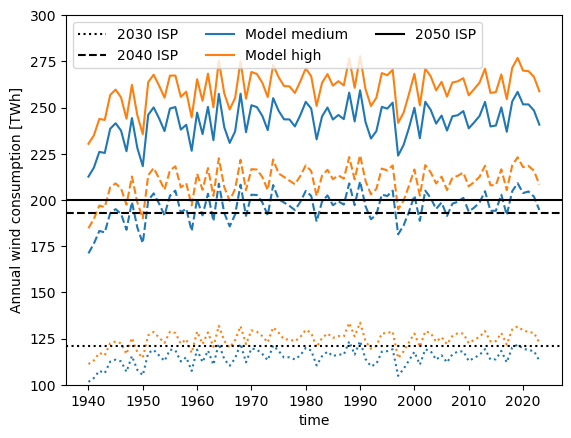

In [63]:
gen_dict["wind_medium_Step_change_wind_2029-30"].plot(color="tab:blue", ls=":")
gen_dict["wind_high_Step_change_wind_2029-30"].plot(color="tab:orange", ls=":")
plt.axhline(121, color="k", ls=":", label="2030 ISP")

gen_dict["wind_medium_Step_change_wind_2039-40"].plot(color="tab:blue", ls="--")
gen_dict["wind_high_Step_change_wind_2039-40"].plot(color="tab:orange", ls="--")
plt.axhline(193, color="k", ls="--", label="2040 ISP")

gen_dict["wind_medium_Step_change_wind_2049-50"].plot(color="tab:blue", label="Model medium")
gen_dict["wind_high_Step_change_wind_2049-50"].plot(color="tab:orange", label="Model high")
plt.axhline(200, color="k", ls="-", label="2050 ISP")

plt.legend(ncols=3)
plt.ylabel("Annual wind consumption [TWh]")
plt.ylim(100, 300)

In [67]:
gen["Step_change_solar_2039-40"].sum()

29843

In [68]:
gen["Step_change_solar_2049-50"].sum()

60343

(0.0, 180.0)

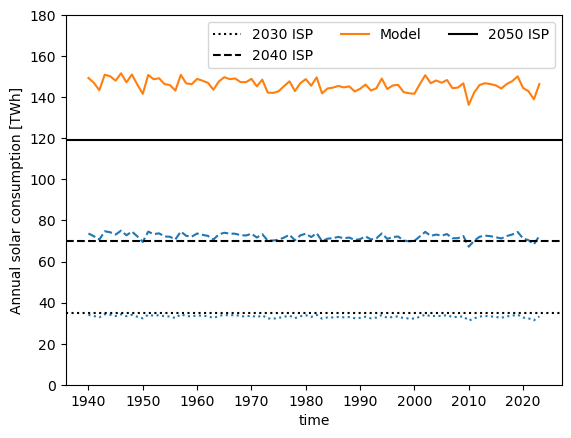

In [66]:
gen_dict["solarpv_Step_change_solar_2029-30"].plot(color="tab:blue", ls=":")
plt.axhline(35, color="k", ls=":", label="2030 ISP")

gen_dict["solarpv_Step_change_solar_2039-40"].plot(color="tab:blue", ls="--")
plt.axhline(70, color="k", ls="--", label="2040 ISP")

gen_dict["solarpv_Step_change_solar_2049-50"].plot(color="tab:orange", label="Model")
plt.axhline(119, color="k", ls="-", label="2050 ISP")

plt.legend(ncols=3)
plt.ylabel("Annual solar consumption [TWh]")
plt.ylim(0, 180)

### Repeat but for existing facilities in sites outside REZs

In [ ]:
solar_outside = xr.open_mfdataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/solar/power/solar_site_outside_REZ_mask_era5.nc",
).solar_site
# Change dimension name so it works with function
solar_outside = solar_outside.rename({"region": "REZ"}).compute()

In [ ]:
wind_outside = xr.open_mfdataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/wind/power/wind_site_outside_REZ_mask_era5.nc",
).wind_site
wind_outside = wind_outside.rename({"region": "REZ"}).compute()

In [ ]:
%%time
for scenario, m in zip(['Existing_solar', 'Existing_wind'], [solar_outside, wind_outside]):
    print(scenario)
#     gen_ds = calc_all_years_generation(years, m, gen[scenario], scale_mask="none")
#     gen_ds = gen_ds.to_dataset(name="power")
    
#     # Tidy path to write
#     if scenario.split("_")[-1] == "(MW)":
#         scenario = scenario[:-5]
#     scenario = scenario.lower()
    
#     gen_ds = gen_ds.rename({"REZ": "region"}) # Change dimension name back
    
#     gen_ds.to_netcdf(
#         fp + "site_outside_REZ_power_" + scenario + "_van_der_Wiel" + "_era5_hourly_" + str(years[0]) + "-" + str(years[-1]) + ".nc",
#         mode="w"
#     )
    calc_all_years_generation("site_outside_REZ_power", years, m, gen[scenario], capacity_factor_scaling=bias_dict, scale_mask="none")

# Close cluster

In [ ]:
client.close()
cluster.close()